In [1]:
import enum
import time
import random
import multiprocessing
from pathlib import Path

seed = 42
training_split_ratio = 0.9 
from unet import UNet
import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
# from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Wed Mar  2 03:42:56 2022
TorchIO version: 0.18.74


In [2]:
# Dataset
dataset_url = 'https://www.dropbox.com/s/ogxjwjxdv5mieah/ixi_tiny.zip?dl=0'
dataset_path = 'ixi_tiny.zip'
dataset_dir_name = 'ixi_tiny'
dataset_dir = Path(dataset_dir_name)
histogram_landmarks_path = 'landmarks.npy'

In [3]:
if not dataset_dir.is_dir():
    !curl --silent --output {dataset_path} --location {dataset_url} 
    !unzip -qq {dataset_path}

In [4]:
images_dir = dataset_dir / 'image'
labels_dir = dataset_dir / 'label'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        brain=tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 566 subjects


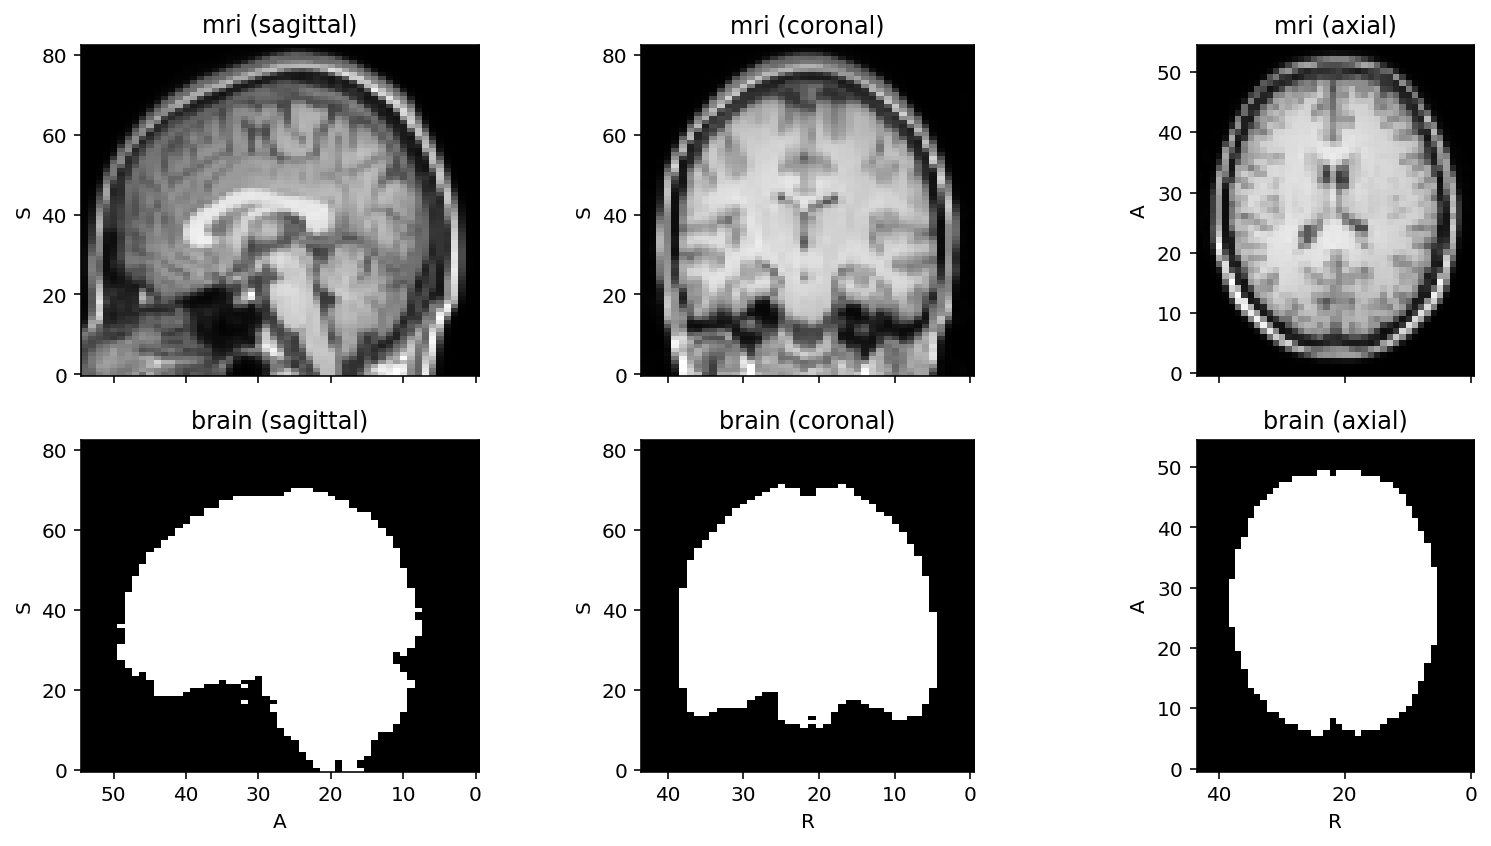

In [5]:
one_subject = dataset[0]
one_subject.plot()

In [6]:
landmarks = tio.HistogramStandardization.train(
    image_paths,
    output_path=histogram_landmarks_path,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

100%|██████████| 566/566 [00:03<00:00, 162.07it/s]


Trained landmarks: [ -0.      0.002   0.108   0.227   0.467   2.014  15.205  34.297  49.664
  55.569  61.178  74.005 100.   ]


In [7]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.RandomMotion(p=0.2),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 509 subjects
Validation set: 57 subjects


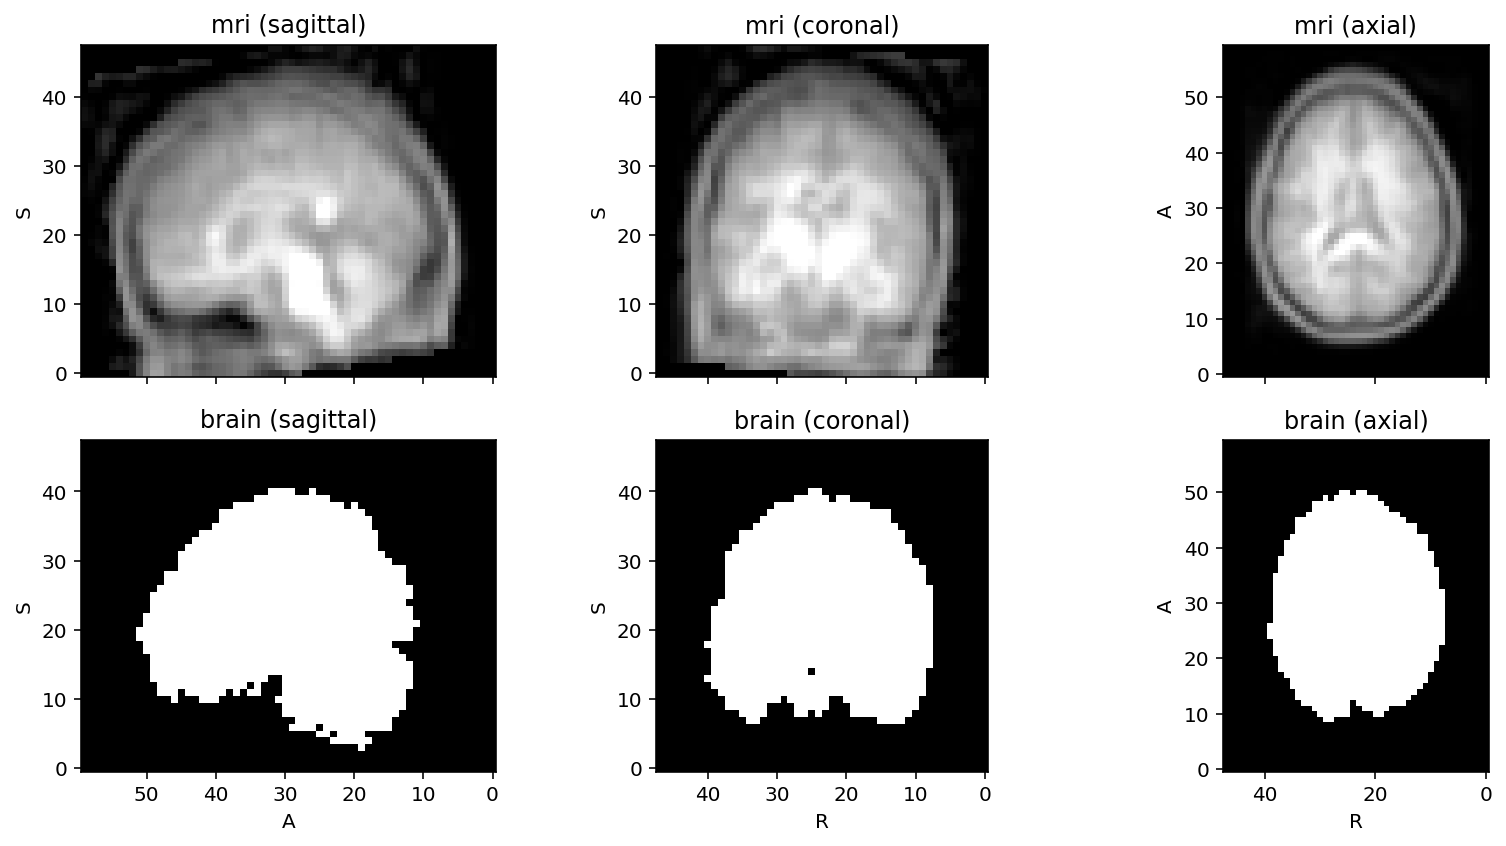

In [8]:
training_instance = training_set[42]  # transform is applied inside SubjectsDataset
training_instance.plot()

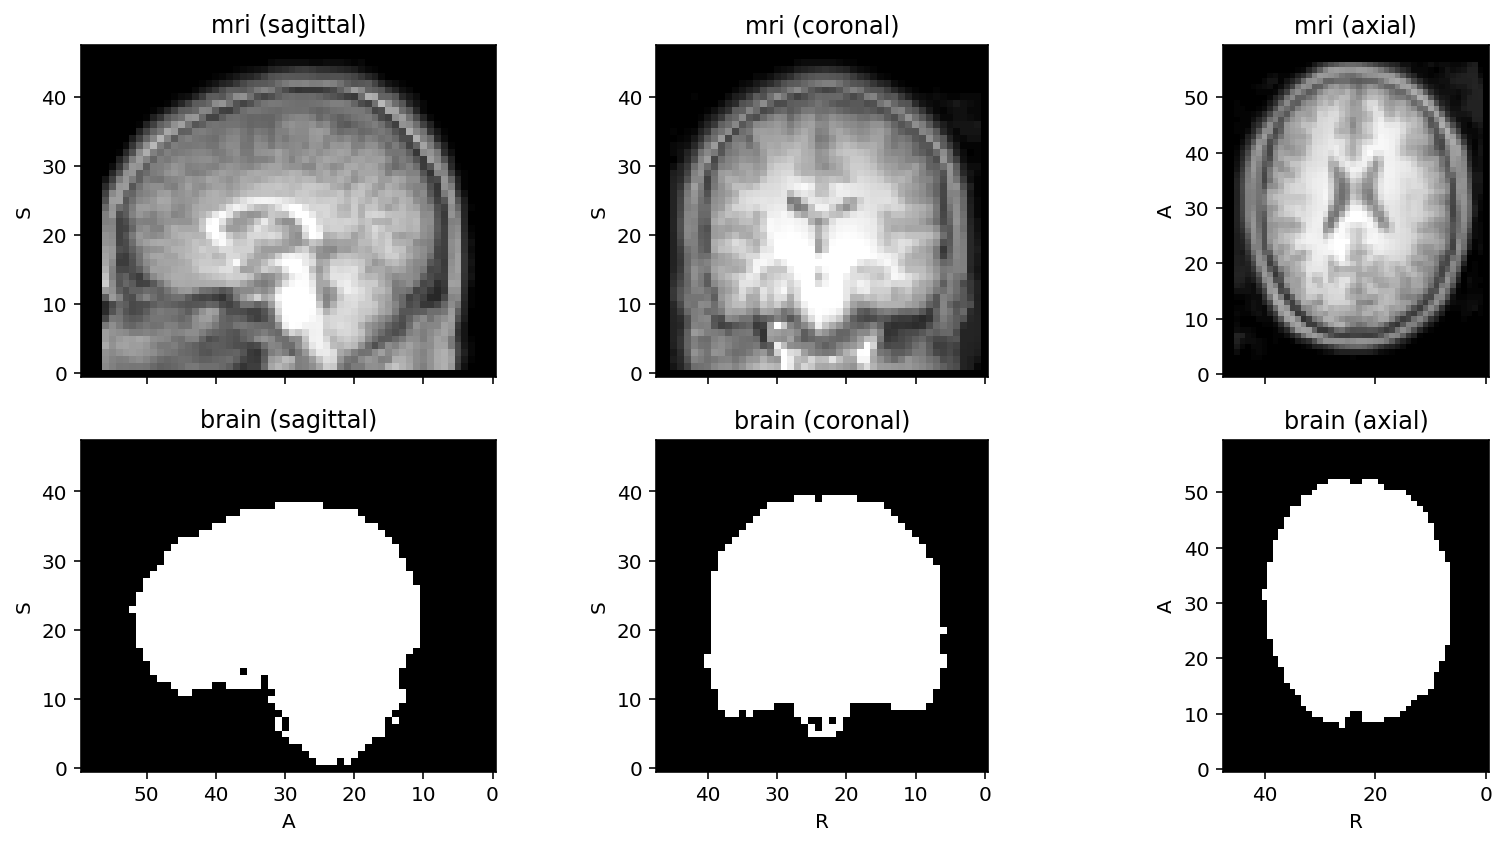

In [9]:
validation_instance = validation_set[42]
validation_instance.plot()

In [10]:
training_batch_size = 16
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=num_workers,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=num_workers,
)

In [11]:
one_batch = next(iter(training_loader))

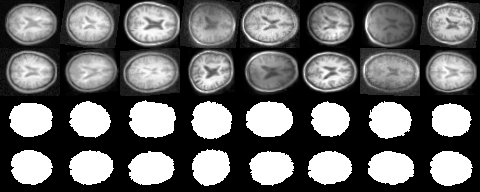

In [12]:
k = 24
batch_mri = one_batch['mri'][tio.DATA][..., k]
batch_label = one_batch['brain'][tio.DATA][:, 1:, ..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_whole_images.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=training_batch_size//2,
    normalize=True,
    scale_each=True,
    padding=0,
)
display.Image(image_path)

In [13]:
train_whole_images = True
num_epochs= 10

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    inputs = batch['mri'][tio.DATA].to(device)
    targets = batch['brain'][tio.DATA].to(device)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
    val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

  0%|          | 0/2 [00:00<?, ?it/s]

/root/miniconda3/envs/project/lib/python3.9/site-packages/unet/decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


Validation mean loss: 0.564
Starting epoch 1


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.343


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.311
Starting epoch 2


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.248


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.207
Starting epoch 3


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.181


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.145
Starting epoch 4


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.129


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.099
Starting epoch 5


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.090


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.069
Starting epoch 6


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.067


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.057
Starting epoch 7


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.053


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.046
Starting epoch 8


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.043


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.034
Starting epoch 9


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.040


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.034
Starting epoch 10


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.035


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.030


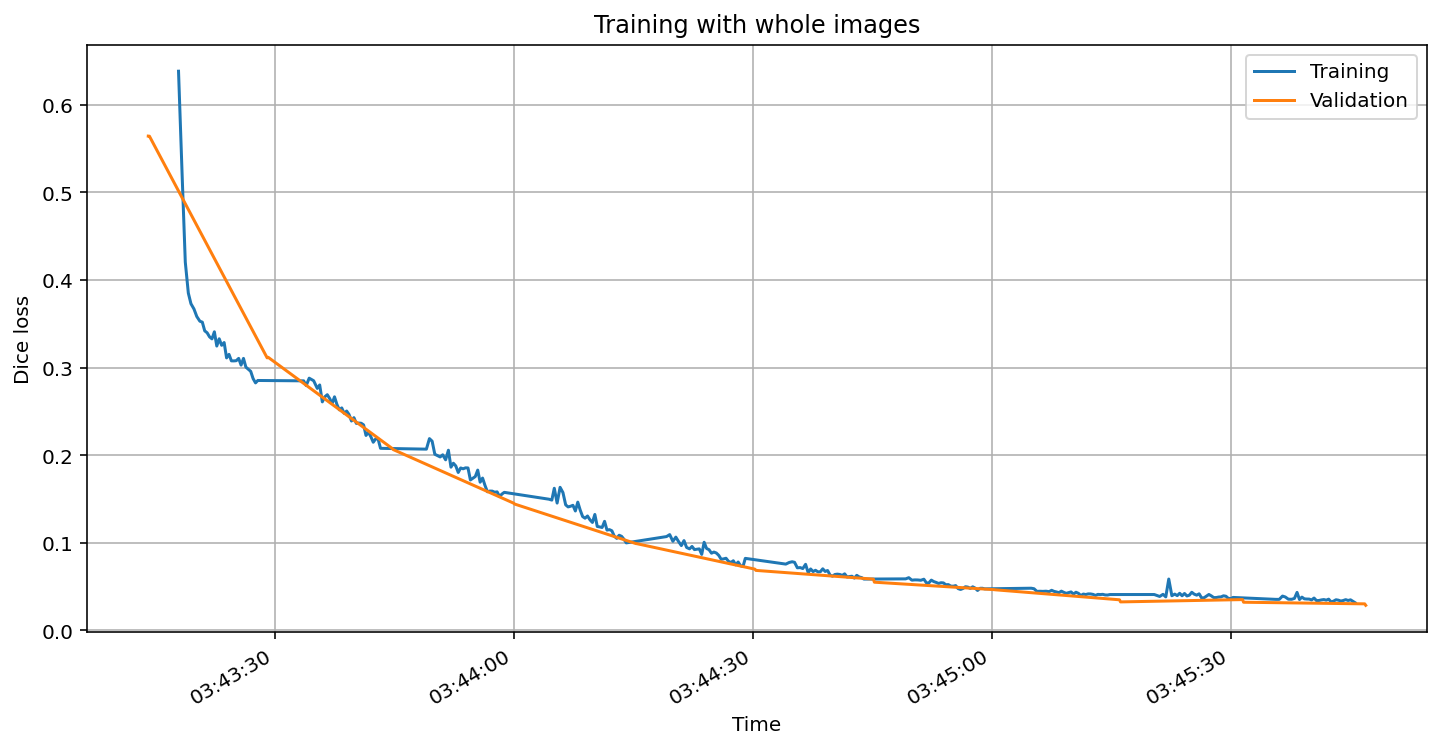

In [15]:
model, optimizer = get_model_and_optimizer(device)
weights_path = 'whole_image_state_dict.pth'
if train_whole_images:
    weights_stem = 'whole_images'
    train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)
    checkpoint = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'weights': model.state_dict(),
    }
    torch.save(checkpoint, weights_path)
else:
    weights_path = 'whole_image_state_dict.pth'
    weights_url = 'https://github.com/fepegar/torchio-data/raw/master/models/whole_images_epoch_5.pth'
    !curl --location --silent --output {weights_path} {weights_url}
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint['weights'])
    train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses']

def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)
    
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with whole images')
ax.legend()
fig.autofmt_xdate()

/root/miniconda3/envs/project/lib/python3.9/site-packages/unet/decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


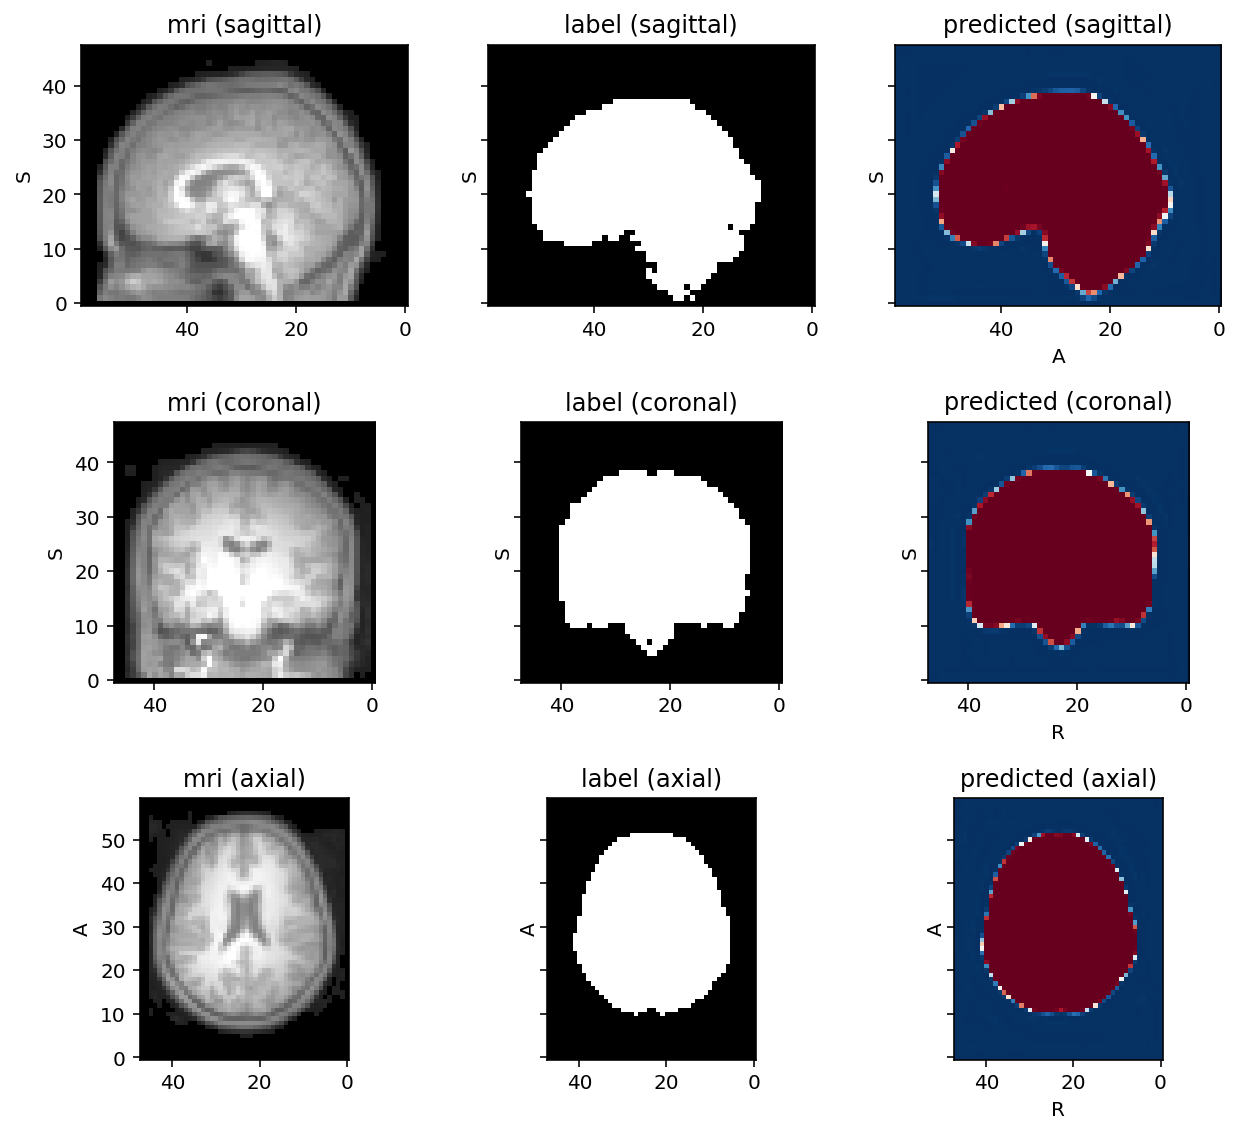

In [16]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
FIRST = 0
FOREGROUND = 1
with torch.no_grad():
    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()
affine = batch['mri'][tio.AFFINE][0].numpy()
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=batch['mri'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['brain'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})